# <span style="color:black; font-weight:bold;">CDOEX Human tonsils Sample Integration Tutorial</span>
+ <span style="color:black; font-weight:bold;">Creator</span>: Bingjie Dai (17516970902@163.com)
+ <span style="color:black; font-weight:bold;">Date of Creation</span>: 10.12.2025
+ <span style="color:black; font-weight:bold;">Date of Last Modification</span>: 10.12.2025
+ <span style="color:black; font-weight:bold;">Download</span>: CDOEX Human tonsils Sample Integration data used in the tutorial are available at [tonsil6677.h5ad](https://drive.google.com/open?id=1gdfHUPcDy8x4vvCjUYLgjl3D7b7ygpSK&usp=drive_fs) , [tonsil8953.h5ad](https://drive.google.com/open?id=10PAAW8UqJogS3DGPBJuFSrgoGlB8971B&usp=drive_fs) and [tonsil9338.h5ad](https://drive.google.com/open?id=1S0NkeQN7jgqRZdagcqrbMf21pA3cN6jU&usp=drive_fs)
In this tutorial we apply SpaLP to 3 Sample Integration (CODEX Human tonsils 6677/8953/9338) of the Human tonsils dataset from [Kennedy-Darling(2021), Highly multiplexed tissue imaging using repeated oligonucleotide exchange reaction. Eur. J. Immunol., 51: 1262-1277.](https://doi.org/10.1002/eji.202048891)

<span style="color:black; font-weight:bold;">The dataset have:</span>   
+ <span style="color:black; font-weight:bold;">CDOEXtonsil6677</span>: 372,546 cells and 43 proteins   
+ <span style="color:black; font-weight:bold;">CODEXtonsil8953</span>: 505,793 cells and 43 proteins  
+ <span style="color:black; font-weight:bold;">CODEXtonsil9338</span>: 517,740 cells and 43 proteins  
+ <span style="color:black; font-weight:bold;">After integration Total</span>: 1,396,079 cells and 43 proteins

In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.RandLA import SpatialAutoencoder
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

## <span style="color:black; font-weight:bold;">Loading CDOEX Human tonsils Sample Integration data</span>

In [4]:
adata1=sc.read_h5ad('/home/dbj/SpaLA/Protein/CODEX/tonsil6677.h5ad')
adata1.obs['batch']='tonsil6677'
adata2=sc.read_h5ad('/home/dbj/SpaLA/Protein/CODEX/tonsil8953.h5ad')
adata2.obs['batch']='tonsil8953'
adata3=sc.read_h5ad('/home/dbj/SpaLA/Protein/CODEX/tonsil9338.h5ad')
adata3.obs['batch']='tonsil9338'
adata1,adata2,adata3

(AnnData object with n_obs × n_vars = 372546 × 43
     obs: 'celltype', 'X', 'Y', 'batch'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 505793 × 43
     obs: 'celltype', 'Y', 'X', 'batch'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 517740 × 43
     obs: 'Y', 'X', 'celltype', 'batch'
     obsm: 'spatial')

In [5]:
adata_batch_list = [adata1,adata2,adata3]
adata = ad.concat(adata_batch_list, join="inner")
adata

AnnData object with n_obs × n_vars = 1396079 × 43
    obs: 'celltype', 'X', 'Y', 'batch'
    obsm: 'spatial'

## <span style="color:black; font-weight:bold;">Data preprocessing</span>
We use [scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) package to preprocess each batch separately and combine them as standard processed expression matrix.

In [6]:
adatas = []
for batch in adata.obs['batch'].unique():
    a = adata[adata.obs['batch'] == batch].copy()
    sc.pp.scale(a)
    adatas.append(a)

adata = ad.concat(adatas, join="inner")
adata.obsm['feat']=adata.X

## <span style="color:black; font-weight:bold;">Compute Spatial Neighbor Graph and build the neighbor index matrix</span>
We compute the Spatial Graph using 4 neighbors in CDOEX Human tonsils Sample Integration dataset. k=4  
We will compute a separate spatial neighbor index matrix for each slice and combine them as disconnected components. 

In [7]:
graphs = []
for batch in adata.obs['batch'].unique():
    a = adata[adata.obs['batch'] == batch].copy()
    graph = prepare_inputs(a, k=4, device=device)
    graphs.append(graph)

In [8]:
all_features = torch.cat([g.features for g in graphs], dim=0)
all_neighbor_idx = []
offset = 0
for g in graphs:
    all_neighbor_idx.append(g.neighbor_idx + offset)
    offset += g.features.shape[0]
all_neighbor_idx = torch.cat(all_neighbor_idx, dim=0)
graph = Graph(all_features, all_neighbor_idx)

## <span style="color:black; font-weight:bold;">Define Parameters</span>
The hidden layer dimension is 15, the Adam optimizer is used to optimize the model, the learning rate lr is 0.001, and the model is trained for 200 epochs.

In [9]:
in_channels = graph.features.shape[1]
model = SpatialAutoencoder(in_channels, out_channels=15).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|████████████████████████████| 200/200 [00:25<00:00,  7.83it/s, Epoch=199, Loss=0.9122]


## <span style="color:black; font-weight:bold;">Generate cell embedding and reconstructed protein expression</span>
Cell embedding was saved in adata.obsm[<span style="color:red;">'SpaLP'</span>]. Reconstructed protein expression is constructed as adata2

In [11]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

### Cell embedding

In [12]:
adata.obsm['SpaLP']=embedding

### Reconstructed protein expression

In [13]:
adata2=sc.AnnData(reconstructed)
adata2.obs=adata.obs
adata2.var=adata.var
adata2.uns=adata.uns
adata2.obsm=adata.obsm

In [14]:
adata.write_h5ad('/home/dbj/SpaLP/CODEX/SpaLP.h5ad')
adata2.write_h5ad('/home/dbj/SpaLP/CODEX/Reconstruction.h5ad')

## <span style="color:black; font-weight:bold;">Identify Niches and Visualization of Multi-slice Integration embedding Using UMAP</span>
We compute Leiden clustering based on the SpaLP embeddings to identify spatial niches.  
Here we recommend using the [rapids_singlecell](https://rapids-singlecell.readthedocs.io/en/latest/) package for Ultra large-scale data, a GPU-version of scanpy

In [1]:
import scanpy as sc
import cupy as cp
import time
import rapids_singlecell as rsc
import warnings
warnings.filterwarnings("ignore")

/home/dbj/anaconda3/envs/rapids_singlecell/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=1,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [3]:
data_load_start = time.time()

## <span style="color:black; font-weight:bold;">Load the embedding and add it to GPU</span>

In [4]:
adata=sc.read_h5ad('/home/dbj/SpaLP/CODEX/SpaLP.h5ad')

In [5]:
rsc.get.anndata_to_GPU(adata)

We compute Leiden clustering based on the SpaLP embeddings to identify spatial niches. 

In [6]:
rsc.pp.neighbors(adata,use_rep='SpaLP')
rsc.tl.umap(adata)
rsc.tl.leiden(adata, resolution=0.4,key_added='SpaLP',random_state=2024)

In [8]:
adata.write_h5ad('/home/dbj/SpaLP/CODEX/SpaLP.h5ad')

## <span style="color:black; font-weight:bold;">Multi-slice Integration embedding</span>

In [6]:
from SpaLP.utils import create_new_color_dict
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")

In [7]:
adata=sc.read_h5ad('/home/dbj/SpaLP/CODEX/SpaLP.h5ad')

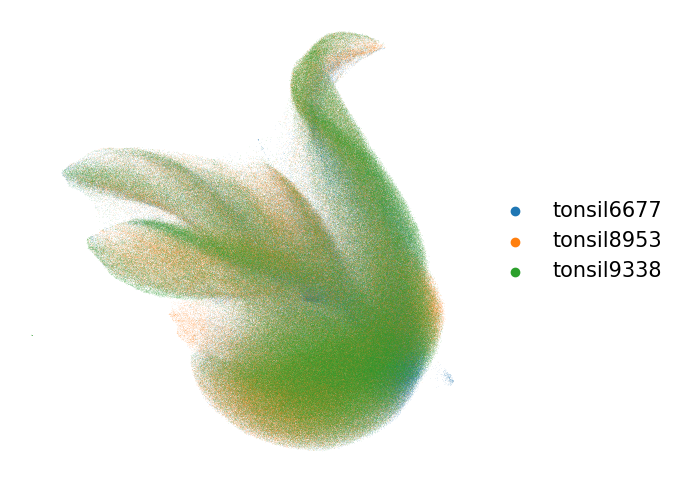

In [8]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['font.size'] = 15
sc.pl.umap(adata=adata,color='batch',title='',size=0.2,colorbar_loc=None,frameon=False)

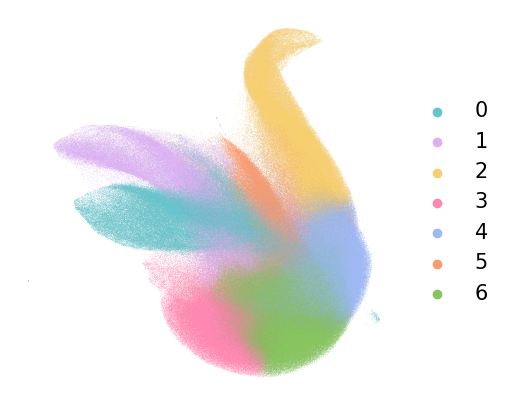

In [9]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='SpaLP')
sc.pl.umap(adata=adata,color='SpaLP',title='',size=0.3,colorbar_loc=None,frameon=False,palette=latent_cluster_colors)

## <span style="color:black; font-weight:bold;">Multi-slice Niche identified by SpaLP</span>

In [12]:
adata.obsm['spatial'][:, 1] = -adata.obsm['spatial'][:, 1]

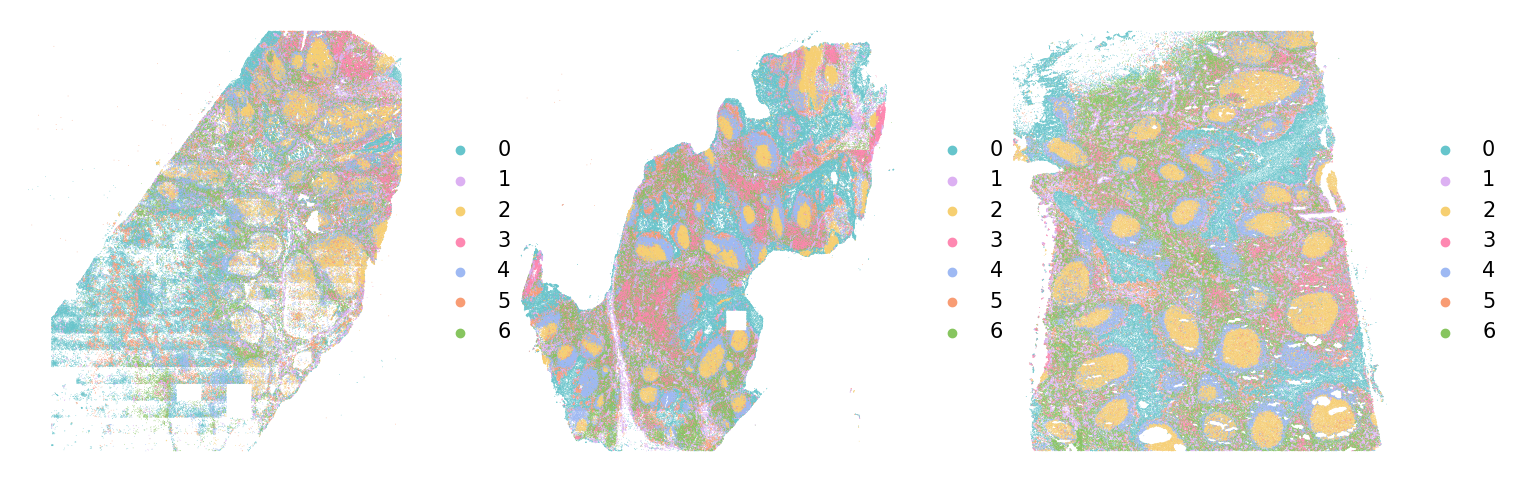

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='SpaLP')
samples = adata.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(6 * len(samples), 6))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['batch'] == sample],basis='spatial',color=['SpaLP'],frameon=False,title='',palette=latent_cluster_colors,ax=axs[idx],show=False,size=1)

### <span style="color:black; font-weight:bold;">Highlight visualization Niche 3 and 6</span>

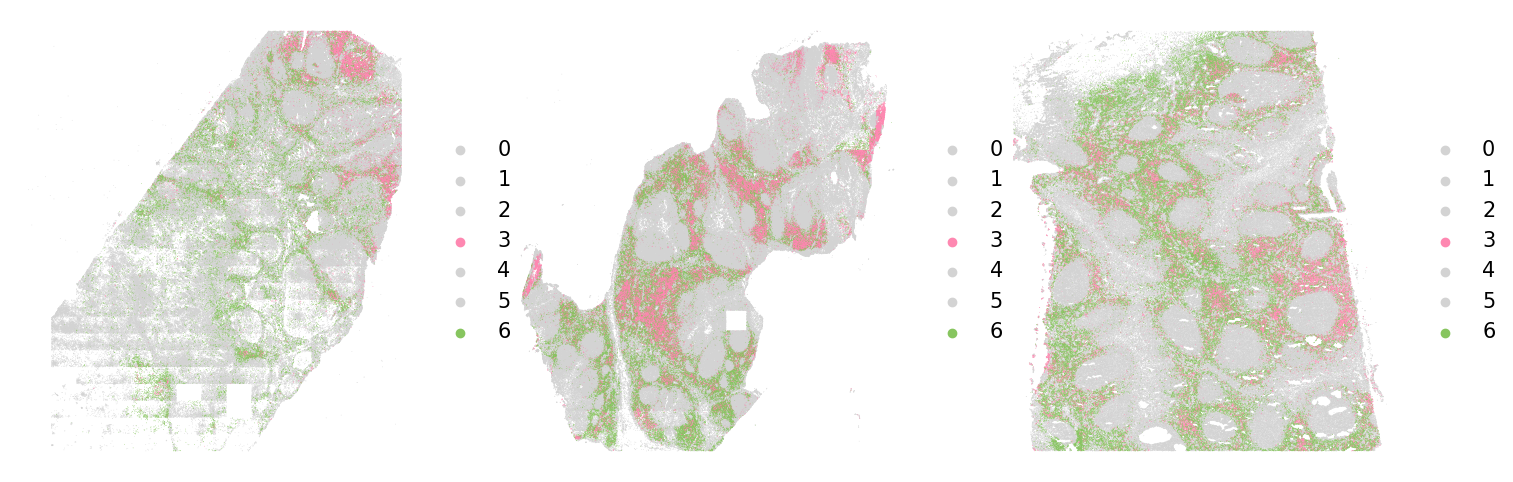

In [14]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15

highlight_colors = copy.deepcopy(latent_cluster_colors)
targets = ['3', '6']
for k in highlight_colors.keys():
    if k not in targets:
        highlight_colors[k] = '#D3D3D3'
        
samples = adata.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(5 * len(samples), 6))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['batch'] == sample],basis='spatial',color=['SpaLP'],frameon=False,title='',palette=highlight_colors,ax=axs[idx],show=False,size=1)

### <span style="color:black; font-weight:bold;">Highlight visualization Niche 3 and 6</span>

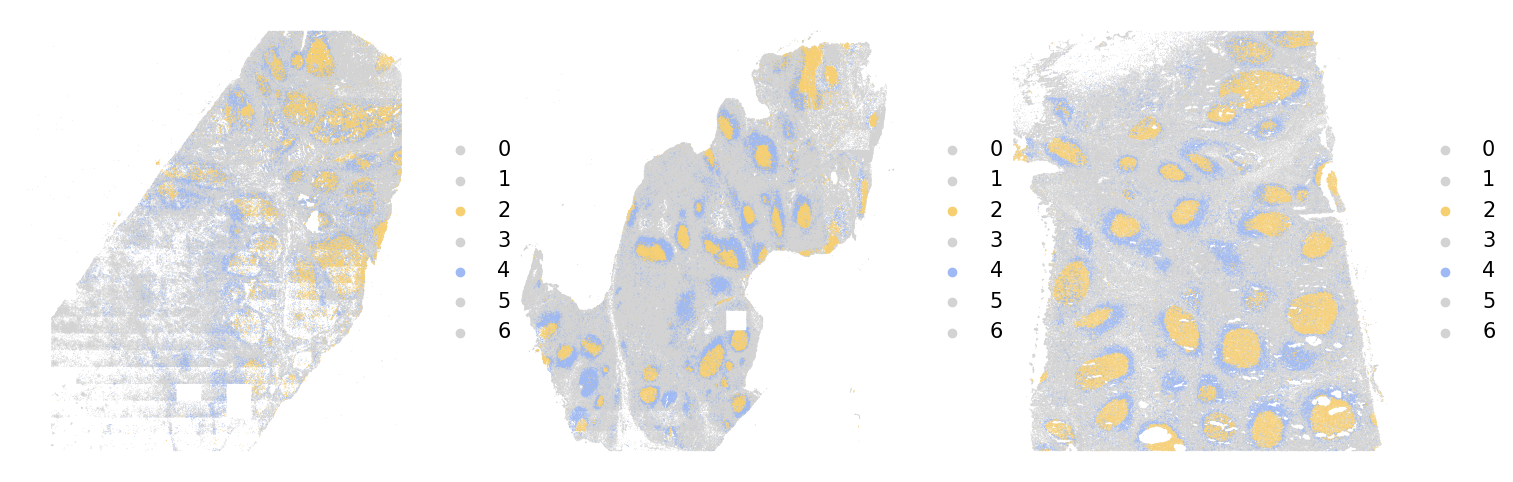

In [15]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15

highlight_colors = copy.deepcopy(latent_cluster_colors)
targets = ['2', '4']
for k in highlight_colors.keys():
    if k not in targets:
        highlight_colors[k] = '#D3D3D3'
        
samples = adata.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(5 * len(samples), 6))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['batch'] == sample],basis='spatial',color=['SpaLP'],frameon=False,title='',palette=highlight_colors,ax=axs[idx],show=False,size=1)

### <span style="color:black; font-weight:bold;">Manual annotation in [original research](https://doi.org/10.1002/eji.202048891)</span>

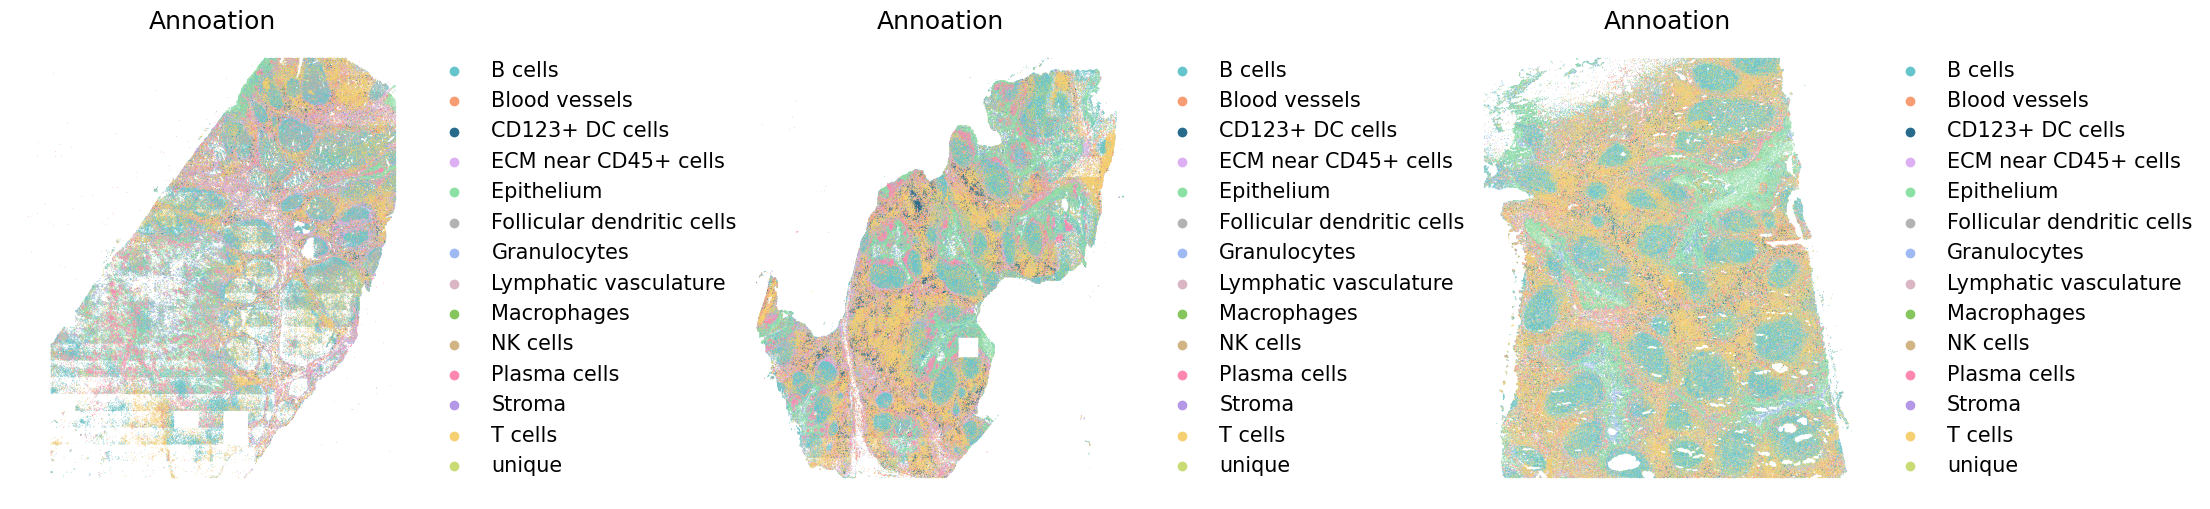

In [27]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15

latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='celltype')
        
samples = adata.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(8 * len(samples), 6))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['batch'] == sample],basis='spatial',color=['celltype'],frameon=False,title='Annoation',palette=latent_cluster_colors,ax=axs[idx],show=False,size=1)
fig.subplots_adjust(wspace=0.8, hspace=0.1)
plt.show()